# Linear Regression Exercise `R`

This exercise is going to be a little different in the sense that we won't be guiding in a question-by-question format. Instead, we are going to let you construct linear model in your choice of `R` or `Python`, whichever you prefer.

The prediction problem is to predict `height` from the `'../../../datasets/stature-hand-foot/stature-hand-foot.csv'` (you may substitute this with another dataset from the dataset directory if you have a regression prediction problem in mind) dataset. You can use any variable or combination of variables in order to predict `height`.

You are not going to be graded upon the performance of the model itself, but please approach this as an actual prediction problem. That being said, you should split the data into training and testing sets, in which your model is trained on your training set while the performance is assessed on the testing set. Be sure to predict some output with your testing inputs.

The purpose of this assignment is to demonstrate your ability to use regression to develop a machine learning model. Feel free to include anything that demonstrates your understanding of model development and model refinement including data exploration and even written description of your reasoning. 

Like always, feel free to ask questions along the way if you get stuck at any point. We are more than happy to help!

In [2]:
library(dplyr)
library(tidyr)
library(caret)
library(ggplot2)
library(gridExtra)
library(grid)
library(lattice)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [3]:
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_blank(),
               #legend.key = element_rect(colour = NA),
               #legend.position = "bottom",
               #legend.direction = "horizontal",
               #legend.key.size= unit(0.2, "cm"),
               #legend.margin = unit(0, "cm"),
               #legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

scale_fill_Publication <- function(...){
      library(scales)
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

scale_colour_Publication <- function(...){
      library(scales)
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

First I'll load the data and see what features I have to work with. I'm renaming the column names to condense a bit. Then I'll summarize the data to see what I can learn from that.

In [4]:
statdata <- read.csv('stature-hand-foot.csv')
colnames(statdata) <- c('gender', 'height', 'hand', 'foot')
summary(statdata)

     gender          height          hand            foot      
 Min.   :1.000   Min.   :1485   Min.   :133.7   Min.   :193.6  
 1st Qu.:1.000   1st Qu.:1604   1st Qu.:189.6   1st Qu.:232.9  
 Median :1.000   Median :1670   Median :200.0   Median :251.4  
 Mean   :1.484   Mean   :1678   Mean   :199.5   Mean   :249.1  
 3rd Qu.:2.000   3rd Qu.:1751   3rd Qu.:208.7   3rd Qu.:263.1  
 Max.   :2.000   Max.   :1889   Max.   :258.0   Max.   :283.1  

Okay, just a few variables. Since I want to be predicting height, I know it will have to be a function of some combination of the other three - gender, hand length, and foot length.

I see that gender implemented as a numeric variable, when really it is categorical. Furthermore, I'm not sure whether 1=male or 2=male. In order to determine this, I'm going to see what the average heights of each gender is, under the assumption that males tend to have larger body parts.

In [5]:
statdata %>%
    group_by(gender) %>%
    summarize(n = length(gender), m_height = mean(height), m_hand = mean(hand), m_foot = mean(foot))

gender,n,m_height,m_hand,m_foot
1,80,1750.565,208.7788,262.5562
2,75,1599.597,189.5800,234.7493


Ok - height, hand, and foot length are all larger, on average, for gender=1 than gender=2. Therefore, I conclude that 1=male, and will adjust the gender variable to denote this (we'll call it sex, since this is really a more appropriate term for the variable than gender anyway).

In [6]:
stature <- statdata %>%
    mutate(sex = ifelse(gender==1,'male','female')) %>%
    select(-gender)
head(stature)

height,hand,foot,sex
1760.2,208.6,269.6,male
1730.1,207.6,251.3,male
1659.6,173.2,193.6,male
1751.3,258.0,223.8,male
1780.6,212.3,282.1,male
1818.3,213.4,268.0,male


Looks good to me!

Now I want to get a sense of how my variables relate to each other. I'll accomplish this by calculating the correlation and plotting some basic plots.

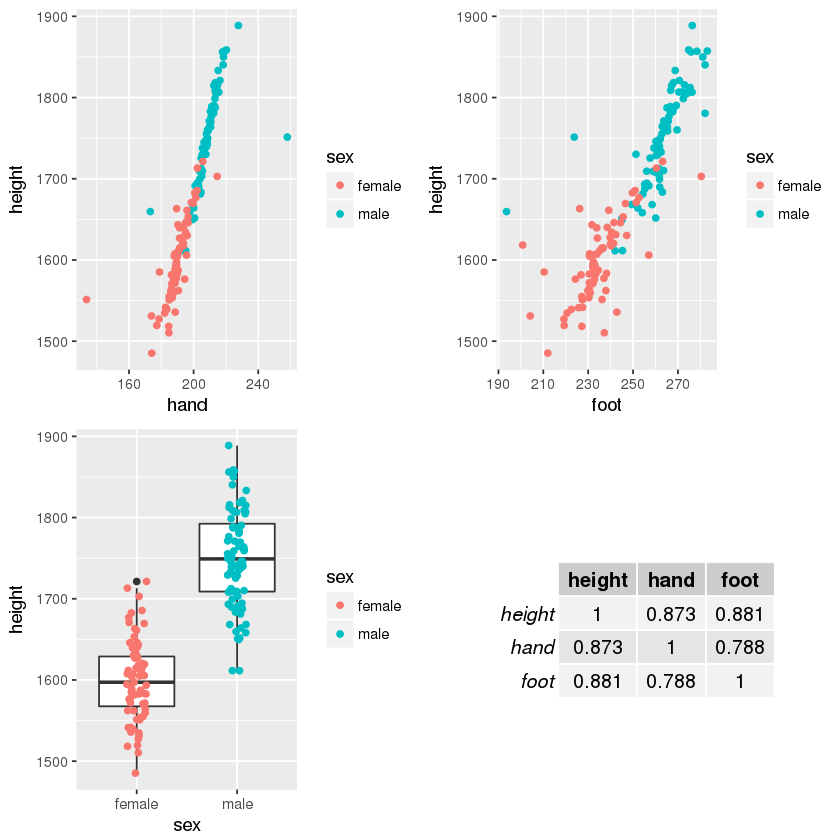

In [7]:
t <- tableGrob(round(cor(stature[,sapply(stature,is.numeric)]), digits=3))
g1 <- ggplot(data=stature, aes(sex, height)) + geom_boxplot() + geom_jitter(width=.1, aes(color=sex))
g2 <- ggplot(data=stature, aes(hand, height)) + geom_point(aes(color=sex))
g3 <- ggplot(data=stature, aes(foot, height)) + geom_point(aes(color=sex))

grid.arrange(g2, g3, g1, t, ncol=2)

Looks pretty straightforward. The graphs for hand vs height and foot vs height show a pretty solid relationship in each. Really, hand looks like an extremely precise predictor of height, in all but a few cases! 

The box plot for sex vs height doesn't tell us much that we didn't expect - males tend to be taller than females, and there is a pretty natural-looking distribution of heights within both sexes. Although there is definitely a relationship between sex and height, it is pretty clear in the top two plots that this relationship is captured pretty well by the hand and foot variables, so I'm guessing at this point that sex is not going to be included in my final model.

To quantify the top two relationships, we can see the correlation table in the bottom-right. But wait, why does foot have a higher correlation to height than hand does? It's pretty clear to me in the plots that hand should have a closer relationship. You know, I bet those couple of outliers are wreaking havoc on the correlation. I want to see what happens if I remove those two individuals with extreme outlier hand lengths.

[1] "2 outliers removed"

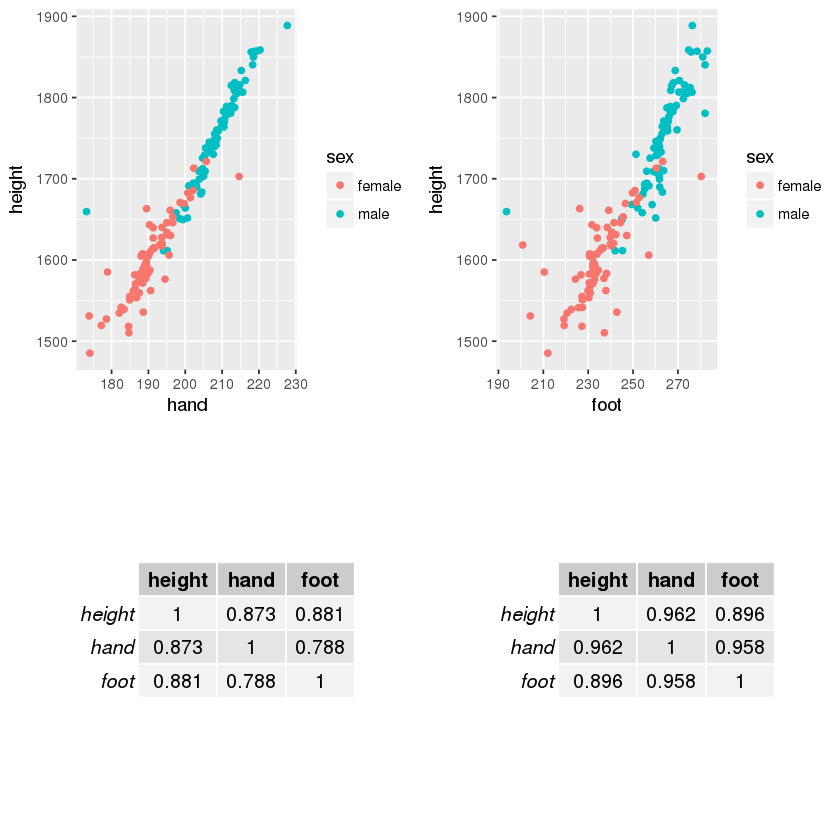

In [56]:
outlier <- stature[stature$hand <= 160 | stature$hand >= 240,]
nooutlier <- stature[stature$hand > 160 & stature$hand < 240,]
paste(nrow(stature)-nrow(nooutlier),"outliers removed")
newt <- tableGrob(round(cor(nooutlier[,sapply(nooutlier,is.numeric)]), digits=3))
g1 <- ggplot(data=nooutlier, aes(sex, height)) + geom_boxplot() + geom_jitter(width=.1)
g2 <- ggplot(data=nooutlier, aes(hand, height)) + geom_point(aes(color=sex))
g3 <- ggplot(data=nooutlier, aes(foot, height)) + geom_point(aes(color=sex))

grid.arrange(g2, g3, t, newt, ncol=2)

Wow! The correlation for hand vs height went up almost 10%! That's a nice correlation!

Based on this knowledge, I'm going to do something that I'm not really sure if it's kosher in the modelling community, but I think it makes sense. I will deliberately exclude these two outliers from my training dataset, and other than them I will randomly assign people randomly to the training and testing.

Another thing I've learned from seeing these graphs is that I'm definitely looking at linear relationships between these predictors and height. So now I'm going to go ahead and make some one-variable linear models.

First I'll separate training and testing data. I'll arbitrarily choose 80% to 20% as the training to testing size.

In [51]:
# START HERE FOR CODE

# Just a smidge of data cleaning
statdata <- read.csv('stature-hand-foot.csv')
colnames(statdata) <- c('gender', 'height', 'hand', 'foot')
data <- statdata %>%
    mutate(sex    = ifelse(gender==1, 'male', 'female'),
           height = height/304.8,
           hand   = hand/25.4) %>%
    select(-gender, -foot)
head(data)

height,hand,sex
5.774934,8.212598,male
5.676181,8.173228,male
5.444882,6.818898,male
5.745735,10.157480,male
5.841864,8.358268,male
5.965551,8.401575,male


In [52]:
# Generate training and testing dataset 
# Train a model
set.seed(123)
train_idx <- sample(seq_len(nrow(data)), nrow(data)*.8)
train <- data[train_idx,]
test <- data[-train_idx,]
paste("Train size:", nrow(train), "Test size:", nrow(test))

hmod <- train(height ~ hand, train, method = "lm")
summary(hmod) 

[1] "Train size: 124 Test size: 31"


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30919 -0.03213 -0.00101  0.03275  0.62760 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.30386    0.14479   2.099   0.0379 *  
hand         0.66190    0.01832  36.132   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09021 on 122 degrees of freedom
Multiple R-squared:  0.9145,	Adjusted R-squared:  0.9138 
F-statistic:  1306 on 1 and 122 DF,  p-value: < 2.2e-16


Now I'm going to generate a linear model for both height ~ hand and height ~ foot, even though it's pretty obvious that hand is going to outperform foot.

In [96]:
# Generate training and testing dataset for the NO (no outlier) attempt
# Train another model.
data.no <- data[data$hand > 6.3 & data$hand < 9.4,]
outliers <- data[data$hand <= 6.3 | data$hand >= 9.4,]
outliers

set.seed(123)
train_idx <- sample(seq_len(nrow(data.no)), nrow(data.no)*.8)
train <- data.no[train_idx,]
test <- rbind(data.no[-train_idx,], outliers)
paste("Train size:", nrow(train), "Test size:", nrow(test))
hmod.no <- train(height ~ hand , train, method = "lm")
summary(hmod.no) 

,height,hand,sex,dist
4,5.745735,10.15748,male,2.303581
84,5.089567,5.26378,female,2.590119


[1] "Train size: 122 Test size: 33"


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30259 -0.03768 -0.00507  0.03643  0.60978 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.42384    0.14167   2.992  0.00337 ** 
hand         0.64692    0.01808  35.788  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08974 on 120 degrees of freedom
Multiple R-squared:  0.9143,	Adjusted R-squared:  0.9136 
F-statistic:  1281 on 1 and 120 DF,  p-value: < 2.2e-16


In [80]:
min(data$height)
max(data$height)

min(data$hand)
max(data$hand)

pred <- predict(hmod, newdata=data)
min(pred)
max(pred)
'\"'

[1] 4.873031

[1] 6.196522

[1] 5.26378

[1] 10.15748

[1] 3.787953

[1] 7.027094

[1] "\""

In [212]:
plot.errors <- function(alldata, data.no, model, rmsd, filename) {
    rmsd <- round(rmsd, 5)
    bestfit.int <- summary(model)$coefficients['(Intercept)', 'Estimate']
    bestfit.slope <- summary(model)$coefficients['hand', 'Estimate']
    
    data.no$predicted <- predict(model, newdata = data.no)
    coords <- data.no %>% 
        mutate(grp = row_number()) %>% 
        select(grp, hand, height, predicted) %>%
        rename(actual = height) %>%
        gather(h.type, height, actual, predicted) 
    
    g <- ggplot(data=alldata, aes(hand, height)) + 
        geom_line(data=coords, aes(hand, height, group = grp), size=0.25) +
        geom_abline(slope = bestfit.slope, intercept = bestfit.int) +
        geom_point(aes(color=sex)) +
        geom_label(data = data.frame(), aes(x = 7.75, y = 4.9, label = paste("RMSD:", rmsd)), size = 5, hjust = 0) +
    
        # Reduced figure limits
        scale_x_continuous(limits = c(6.75, 9), expand = c(0, 0)) +
        scale_y_continuous(limits = c(4.75, 6.25), expand = c(0, 0), 
                           breaks=seq(4, 7, 0.5), labels=c("4'0\"", "4'6\"", "5'0\"", "5'6\"", "6'0\"", "6'6\"", "7'0\"")) +
        
        # Full figure limits
        #scale_x_continuous(limits = c(5, 10.5), expand = c(0, 0)) +
        #scale_y_continuous(limits = c(3.78, 7.03), expand = c(0, 0), 
        #                   breaks=seq(4, 7, 0.5), labels=c("4'0\"", "4'6\"", "5'0\"", "5'6\"", "6'0\"", "6'6\"", "7'0\"")) +
    
        labs(x = 'Hand Size (in)', y = 'Height') +
        scale_color_manual(values=c("#ED58BD","#34B0C2")) +
        
        theme_Publication() +
        theme(
            legend.justification = c(1,0), legend.position = c(0.95,0.05)
        )
    ggsave(file=filename, g, dpi=100)
    return(g)
}
#plot.errors(data, data.no, hmod.no, 0.135951231, "")

In [213]:
plot.timeline <- function(series, filename) {
    t <- ggplot(data=series, aes(x=outliers, y=RMSD)) +
        geom_line(color='red', size=0.75) +
        scale_x_continuous(limits=c(0,80), expand=c(0,0), breaks=c(0,20,40,60,80)) +
        scale_y_continuous(limits=c(0.045, 0.123), expand=c(0,0)) +
        labs(x = 'Outliers', y = 'RMSD') +
        theme_Publication() +
        theme(
            panel.grid.major = element_blank()
            )
    t
    ggsave(file=filename, t, height=2, width=3, dpi=100)
}
plot.timeline(results, "timeline.png")

In [214]:
model.core <- function(alldata, train, test, n.outliers) {
    meanhand <- mean(train$hand)
    train$dist <- abs(meanhand - train$hand)
    train.no <- train[order(-train$dist),][(n.outliers+1):nrow(train),]
    cat(paste("Train:", min(train.no$hand), "->", max(train.no$hand), "\n"))

    hmod.no <- train(height ~ hand , train.no, method = "lm")
    rmsd <- RMSD(test$height, predict(hmod.no, newdata=test))
    
    #cat(paste("Train size:", nrow(train.no), "RMSD:", rmsd, "\n", sep=' ')) 
    plot.errors(alldata, rbind(train.no, test), hmod.no, rmsd, paste("BestFit", n.outliers, ".png", sep=''))
    
    return(rmsd)
}

set.seed(12345)
train_idx <- sample(seq_len(nrow(data)), nrow(data)*.8)
train <- data[train_idx,]
test <- data[-train_idx,]
cat(paste("Test:", min(test$hand), "->", max(test$hand), "\n"))

paste("Train size:", nrow(train), "Test size:", nrow(test))

results <- data.frame(outliers=numeric(), rmsd=numeric())
for (i in 0:80) {# Switch to 0:50
    results <- rbind(results, data.frame(outliers=i, rmsd=model.core(data, train, test, i)))
    plot.timeline(results, paste("timeline", i, ".png", sep=''))
}

#results

Test: 6.97637795275591 -> 8.96456692913386 


[1] "Train size: 124 Test size: 31"

Train: 5.26377952755905 -> 10.1574803149606 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


Train: 6.81889763779528 -> 10.1574803149606 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 6.81889763779528 -> 8.67322834645669 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 6.84645669291339 -> 8.67322834645669 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 6.85433070866142 -> 8.67322834645669 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.03149606299213 -> 8.67322834645669 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.03149606299213 -> 8.60236220472441 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.04330708661417 -> 8.60236220472441 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.16929133858268 -> 8.60236220472441 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.16929133858268 -> 8.59448818897638 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.16929133858268 -> 8.47244094488189 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.19291338582677 -> 8.47244094488189 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.19291338582677 -> 8.45669291338583 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.26771653543307 -> 8.45669291338583 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.26771653543307 -> 8.4488188976378 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.26771653543307 -> 8.4488188976378 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.26771653543307 -> 8.43307086614173 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.26771653543307 -> 8.42125984251969 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.26771653543307 -> 8.41338582677165 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.26771653543307 -> 8.40157480314961 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.26771653543307 -> 8.40157480314961 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.26771653543307 -> 8.39763779527559 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.26771653543307 -> 8.39370078740157 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.26771653543307 -> 8.37007874015748 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.27165354330709 -> 8.37007874015748 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.27952755905512 -> 8.37007874015748 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.27952755905512 -> 8.37007874015748 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.31889763779528 -> 8.37007874015748 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.31889763779528 -> 8.36614173228346 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.31889763779528 -> 8.35826771653543 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.31889763779528 -> 8.33858267716536 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.31889763779528 -> 8.31496062992126 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.33858267716535 -> 8.31496062992126 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.33858267716535 -> 8.30314960629921 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.35433070866142 -> 8.30314960629921 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.35433070866142 -> 8.29133858267716 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.38188976377953 -> 8.29133858267716 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.38188976377953 -> 8.28740157480315 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.38188976377953 -> 8.28346456692914 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.38188976377953 -> 8.26377952755906 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.38188976377953 -> 8.26377952755906 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.40157480314961 -> 8.26377952755906 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.40157480314961 -> 8.22834645669291 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.40944881889764 -> 8.22834645669291 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.41732283464567 -> 8.22834645669291 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.42125984251969 -> 8.22834645669291 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.42125984251969 -> 8.22834645669291 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.4251968503937 -> 8.22834645669291 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.4251968503937 -> 8.22047244094488 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.43700787401575 -> 8.22047244094488 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.43700787401575 -> 8.21653543307087 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.43700787401575 -> 8.21259842519685 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.44094488188976 -> 8.21259842519685 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.44094488188976 -> 8.19685039370079 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.44488188976378 -> 8.19685039370079 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.44488188976378 -> 8.19685039370079 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.4488188976378 -> 8.19685039370079 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.45275590551181 -> 8.19685039370079 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.46062992125984 -> 8.19685039370079 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.46062992125984 -> 8.18897637795276 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.46062992125984 -> 8.18897637795276 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.46062992125984 -> 8.18897637795276 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.46456692913386 -> 8.18897637795276 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.46456692913386 -> 8.18503937007874 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.47637795275591 -> 8.18503937007874 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.47637795275591 -> 8.18503937007874 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.47637795275591 -> 8.17322834645669 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.47637795275591 -> 8.17322834645669 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.48031496062992 -> 8.17322834645669 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.48031496062992 -> 8.16535433070866 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.48818897637795 -> 8.16535433070866 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.48818897637795 -> 8.15354330708661 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.49212598425197 -> 8.15354330708661 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.49606299212599 -> 8.15354330708661 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.50393700787402 -> 8.15354330708661 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.50393700787402 -> 8.12992125984252 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.53149606299213 -> 8.12992125984252 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.53149606299213 -> 8.12992125984252 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.53149606299213 -> 8.11417322834646 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.53149606299213 -> 8.11417322834646 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

Train: 7.53149606299213 -> 8.11417322834646 


Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

In [200]:
test$hand

[1] 8.212598 6.818898 8.129921 8.059055 8.358268 8.602362 7.850394 8.055118
 [9] 7.775591 8.401575 8.023622 8.039370 8.196850 7.854331 8.618110 8.641732
[17] 7.740157 8.448819 7.543307 7.440945 7.681102 7.271654 7.622047 7.381890
[25] 7.677165 7.334646 7.318898 7.625984 7.460630 7.716535 7.444882

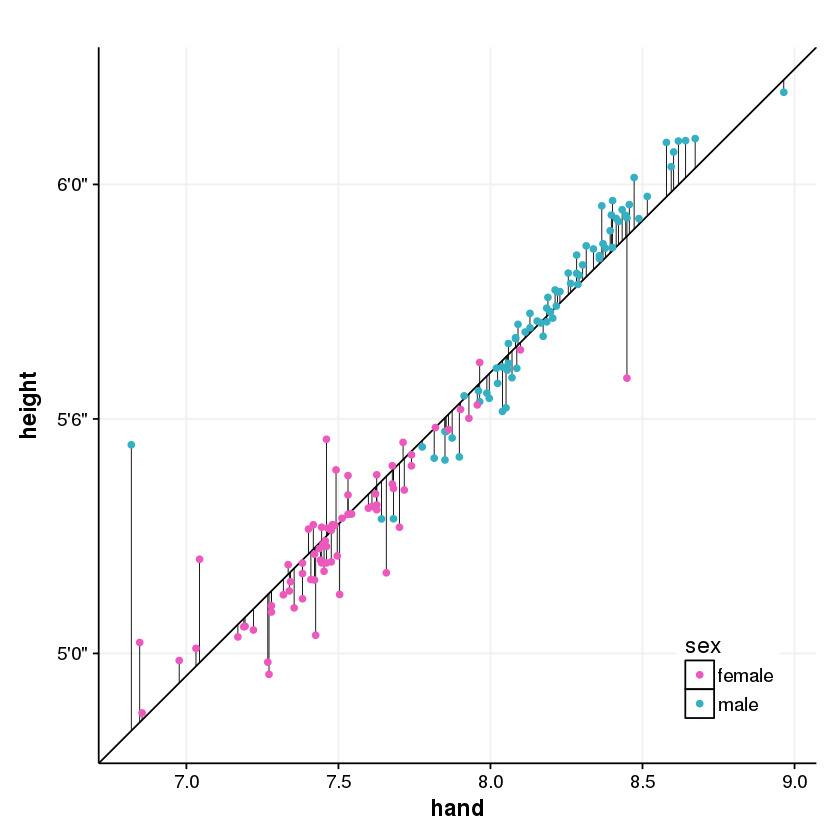

In [76]:

lm.int <- summary(hmod.no)$coefficients['(Intercept)', 'Estimate']
lm.slope <- summary(hmod.no)$coefficients['hand', 'Estimate']

data.no$predicted <- predict(hmod.no, newdata = data.no)
coords <- data.no %>% 
    mutate(grp = row_number()) %>% 
    select(grp, hand, height, predicted) %>%
    rename(actual = height) %>%
    gather(h.type, height, actual, predicted) 

g <- ggplot(data=data.no, aes(hand, height)) + 
    geom_line(data=coords, aes(hand, height, group = grp), size=0.25) +
    geom_abline(slope = lm.slope, intercept = lm.int) +
    geom_point(aes(color=sex)) +
    scale_y_continuous(breaks=seq(4, 7, 0.5), labels=c("4'0\"", "4'6\"", "5'0\"", "5'6\"", "6'0\"", "6'6\"", "7'0\"")) +
    scale_color_manual(values=c("#ED58BD","#34B0C2")) +
    theme_Publication() +
    theme(
        legend.justification = c(1,0), legend.position = c(0.95,0.05)
    )
g
# ggsave(file="test.jpeg", g)

In [106]:
summary(fmod)


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-113.178  -21.065   -2.489   17.376  230.319 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 566.5648    54.5683   10.38   <2e-16 ***
foot          4.4562     0.2169   20.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 44.53 on 122 degrees of freedom
Multiple R-squared:  0.7758,	Adjusted R-squared:  0.774 
F-statistic: 422.2 on 1 and 122 DF,  p-value: < 2.2e-16


So far it looks like the hand model is better (as expected), but let's go ahead an assess that using our test dataset.

Below I'm going to define a function to calculate the RMSD comparing actual and predicted values. Don't worry too much about the specifics of the function for now - I will explain in more detail later.

In [113]:
RMSD <- function(actual, pred, M=mean) {
    data.frame('actual' = actual, 'pred' = pred) %>%
        mutate(se = (actual - pred)^2) %>%
        summarize(RMSD = sqrt(M(se)))
}

Now I'll assess the hand and foot models. Note that smaller RMSDs are indicative of a better model.

In [11]:
paste("Hand model RMSD:",RMSD(test$height, predict(hmod, newdata = test)))
paste("Foot model RMSD:",RMSD(test$height, predict(fmod, newdata = test)))

[1] "Hand model RMSD: 96.0124668402878"

[1] "Foot model RMSD: 54.6960830303558"

Interesting: so the adjusted R-squared values of the model training process indicated that the hand model was quite a bit better (0.9136 adj-R^2 for hand vs. 0.8011 for foot), but here the foot model had a considerably lower RMSD. This is probably largely because of those two outliers that I mentioned earlier. What happens if I take them out of the testing set as well?

In [12]:
noouttest <- filter(test, hand > 160 & hand < 240)
paste("Hand model RMSD:",RMSD(noouttest$height, predict(hmod, newdata=noouttest)))
paste("Foot model RMSD:",RMSD(noouttest$height, predict(fmod, newdata=noouttest)))

[1] "Hand model RMSD: 19.3709266645786"

[1] "Foot model RMSD: 43.0366268955534"

Similarly to the change in correlation above, we see a drastic reduction in RMSD of the hand model predictions after removing these outliers from the test set. I still feel a little weird doing this, so let's take a closer look at what's happening at the residual level.

*This may not be the direction that you want me to go with this assignment, but I'm having fun and think this is actually a legitimate train of thought, so I hope you'll just roll with me here. I'm going to take you on a ride that has less to do with the mechanics of linear model generation and more to do with LM theory.*

Below I use the models to predict values from the test set, compare to the actual values to get absolute value residuals, then generate box plots of these residuals.

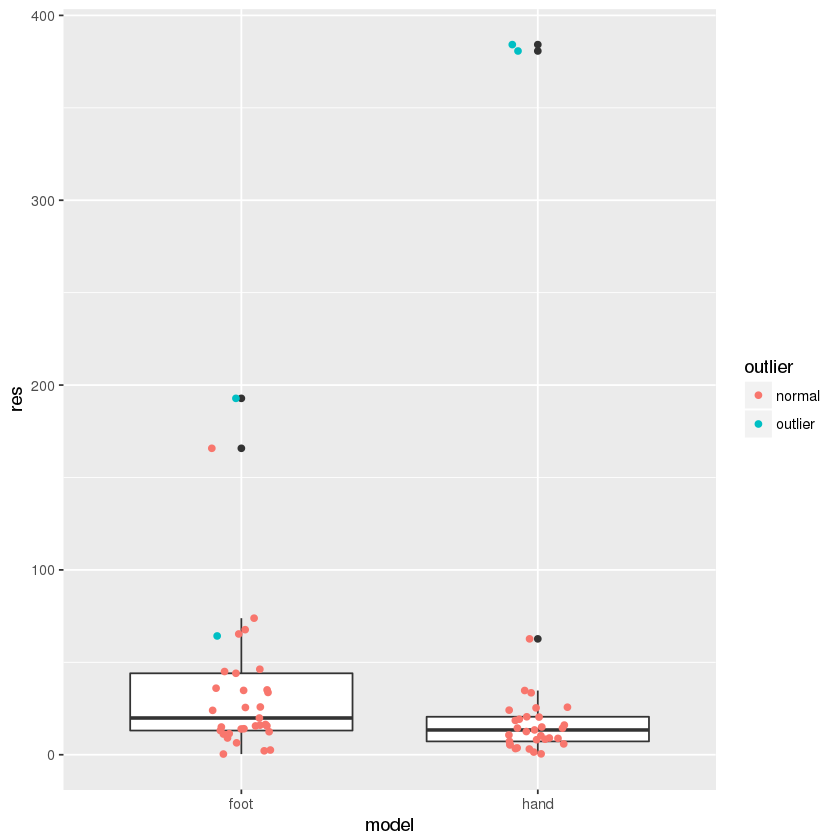

In [13]:
h_res <- test %>%
    mutate(pred = predict(hmod, newdata=test)) %>%
    mutate(model = 'hand')
f_res <- test %>%
    mutate(pred = predict(fmod, newdata=test)) %>%
    mutate(model = 'foot')

residuals <- rbind(h_res, f_res)  %>%
    mutate(res = abs(height-pred)) %>%
    mutate(outlier = ifelse(hand > 160 & hand < 240, 'normal','outlier')) 

ggplot(data=residuals, aes(x=model, y=res)) + 
    geom_boxplot() + geom_jitter(width=.1, aes(color=outlier)) 

With these box plots, we can see just how extreme of an effect these outliers are having on the hand model. Without them, the remaining residuals would all be quite low, but we already knew that since we previously calculated the RMSD using the filtered test set.

Preferably, we could just use a metric that is more resistant to outliers than RMSD. Oh wait, there is a mean-like metric that is resiliant to outliers - the median! In fact, we can already see by looking at the box plots above that the median residual is smaller for the hand model. So can we use median instead of mean when assessing the models? Let's try!

Remember how I said not to look too closely at that RMSD function above? Well, it turns out that I wrote it in such a way that the "M" is flexible. Generally, the "M" in RMSD stands for Mean, but I've decided that I want to use M=median instead, to get the Root-**Median**-Squared-Deviation. My handy-dandy function can handle this change quite easily.

In [14]:
paste("Hand model R-Median-SD:",RMSD(test$height, predict(hmod, newdata=test), M=median))
paste("Foot model R-Median-SD:",RMSD(test$height, predict(fmod, newdata=test), M=median))

[1] "Hand model R-Median-SD: 13.4150028228385"

[1] "Foot model R-Median-SD: 19.8764345972368"

Aha! Using that version of the RMSD, the hand model outperforms the foot model even when we still have the outliers in the test dataset!

But hold on, let's think about what using this median-based metric *means* (haha ... sorry, it's late). Minimizing a mean-based metric reduces the overall error of the predictions, and this error would be spread more evenly across all predicted values. On the other hand, prioritizing a median-based metric during the model-selection process would result in a predictor that was as accurate as possible for the best half of the predictions, with little regard for the worst half of predictions. That doesn't sound that great, to have a predictor that has a 50% chance of having a really good prediction and a 50% chance of having a bad prediction, so let's do better.

Really, there's no reason we have to use the median for our modified RMSD. The median is just a specific *quantile*, so let's pick a new quantile that serves our purposes better. This choice would really depend on the specific purpose of the predictor, but I'll assume here that we're going to be happy maximizing the predictive power for 90% of people.

In [15]:
# Define a quick function that will calculate the 90th percentile
q90 <- function(x) { quantile(x, 0.9) }
paste("Hand model R-90q-SD:",RMSD(test$height, predict(hmod, newdata=test), q90))
paste("Foot model R-90q-SD:",RMSD(test$height, predict(fmod, newdata=test), q90))

[1] "Hand model R-90q-SD: 34.5032470491244"

[1] "Foot model R-90q-SD: 67.2060878280394"

At this point I feel like I'm just getting the results that I want, but I think I've demonstrated a concept that makes general sense. When training a model, you have to have some metric of determining what the best model is. Generally for a linear regression model like this you would use the Root Mean Squared Error, which is generally a pretty good metric. My argument here is that there could be cases when it is more beneficial to train the model to maximize the benefit for most cases and to ignore the remaining ones to some extent. 

In such a case, the model can be trained on data filtered for outliers. Then, by using a percentile-based metric like my modified RMSD, the model can be assessed for its ability to predict the outcome for the majority of people, without having to filter the testing dataset for outliers. It is important that this is the case, as we may not necessarily know about such extreme outliers when utilizing the model to make real predictions. 

In this example, the outliers were defined based strictly on one of the metrics that we would theoretically know when trying to make the prediction (hand length), so it would be possible to screen new predictions by that measurement and give warning that the model is not suited to making predictions about that individual. In fact, we might make multiple models based on a segmented population, like having one model for predicting the height of people with hand size under 160, a model for hand size over 240, and a main model for everything in between (that wouldn't work very well here, due to lack of data, but still). However, I think that this proposed method will be pretty resiliant even to outliers in the predicted variable, which would be more valuable than the situation in this project.

So yeah. My final answer is this model trained on a non-outlier partition of the stature data, with the caveat that it is not designed to be a the best predictor across the spectrum, but rather the best predictor for the most typical 90% or so of people.